In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/My Drive/classification.zip"

Archive:  /content/gdrive/My Drive/classification.zip
   creating: classification/
   creating: classification/seg_test/
   creating: classification/seg_test/buildings/
  inflating: classification/seg_test/buildings/20057.jpg  
  inflating: classification/seg_test/buildings/20060.jpg  
  inflating: classification/seg_test/buildings/20061.jpg  
  inflating: classification/seg_test/buildings/20064.jpg  
  inflating: classification/seg_test/buildings/20073.jpg  
  inflating: classification/seg_test/buildings/20074.jpg  
  inflating: classification/seg_test/buildings/20078.jpg  
  inflating: classification/seg_test/buildings/20083.jpg  
  inflating: classification/seg_test/buildings/20094.jpg  
  inflating: classification/seg_test/buildings/20096.jpg  
  inflating: classification/seg_test/buildings/20113.jpg  
  inflating: classification/seg_test/buildings/20131.jpg  
  inflating: classification/seg_test/buildings/20140.jpg  
  inflating: classification/seg_test/buildings/20177.jpg  
  inf

In [0]:
data_dir="classification"
train_dir = data_dir + '/seg_train'
valid_dir = data_dir + '/seg_test'
nThreads = 4
batch_size = 32

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving categories.json to categories.json
User uploaded file "categories.json" with length 126 bytes


In [0]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)

In [7]:
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [0]:
#Organizing the dataset
data_dir = '/classification'
train_dir = data_dir + '/seg_train'
valid_dir = data_dir + '/seg_test'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [0]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'seg_train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir ="classification"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['seg_train', 'seg_test']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['seg_train', 'seg_test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['seg_train', 'seg_test']}

class_names = image_datasets['seg_train'].classes

In [11]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 94192923.62it/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['seg_train', 'seg_test']:
            if phase == 'seg_train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'seg_train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'seg_train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'seg_test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
use_gpu = torch.cuda.is_available()

In [15]:
# Train a model with a pre-trained network
num_epochs = 15
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Using GPU: True
Epoch 1/15
----------
seg_train Loss: 0.6302 Acc: 0.7641
seg_test Loss: 0.3374 Acc: 0.8683

Epoch 2/15
----------
seg_train Loss: 0.5351 Acc: 0.8006
seg_test Loss: 0.4024 Acc: 0.8427

Epoch 3/15
----------
seg_train Loss: 0.5103 Acc: 0.8080
seg_test Loss: 0.3043 Acc: 0.8887

Epoch 4/15
----------
seg_train Loss: 0.4864 Acc: 0.8182
seg_test Loss: 0.2780 Acc: 0.8970

Epoch 5/15
----------
seg_train Loss: 0.4684 Acc: 0.8235
seg_test Loss: 0.2735 Acc: 0.8937

Epoch 6/15
----------
seg_train Loss: 0.4101 Acc: 0.8451
seg_test Loss: 0.2540 Acc: 0.9013

Epoch 7/15
----------
seg_train Loss: 0.4145 Acc: 0.8462
seg_test Loss: 0.2543 Acc: 0.9020

Epoch 8/15
----------
seg_train Loss: 0.4065 Acc: 0.8460
seg_test Loss: 0.2617 Acc: 0.9047

Epoch 9/15
----------
seg_train Loss: 0.4089 Acc: 0.8458
seg_test Loss: 0.2509 Acc: 0.9020

Epoch 10/15
----------
seg_train Loss: 0.4048 Acc: 0.8472
seg_test Loss: 0.2467 Acc: 0.9027

Epoch 11/15
----------
seg_train Loss: 0.3956 Acc: 0.8513
seg_t

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['seg_test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['seg_test'])))



In [17]:
test(model, dataloaders, device)

Testing Accuracy: 0.010
Testing Accuracy: 0.021
Testing Accuracy: 0.030
Testing Accuracy: 0.039
Testing Accuracy: 0.048
Testing Accuracy: 0.057
Testing Accuracy: 0.066
Testing Accuracy: 0.075
Testing Accuracy: 0.084
Testing Accuracy: 0.094
Testing Accuracy: 0.103
Testing Accuracy: 0.113
Testing Accuracy: 0.122
Testing Accuracy: 0.131
Testing Accuracy: 0.141
Testing Accuracy: 0.151
Testing Accuracy: 0.161
Testing Accuracy: 0.171
Testing Accuracy: 0.181
Testing Accuracy: 0.190
Testing Accuracy: 0.201
Testing Accuracy: 0.210
Testing Accuracy: 0.219
Testing Accuracy: 0.228
Testing Accuracy: 0.237
Testing Accuracy: 0.247
Testing Accuracy: 0.256
Testing Accuracy: 0.267
Testing Accuracy: 0.276
Testing Accuracy: 0.285
Testing Accuracy: 0.295
Testing Accuracy: 0.304
Testing Accuracy: 0.313
Testing Accuracy: 0.323
Testing Accuracy: 0.333
Testing Accuracy: 0.343
Testing Accuracy: 0.353
Testing Accuracy: 0.363
Testing Accuracy: 0.373
Testing Accuracy: 0.384
Testing Accuracy: 0.394
Testing Accuracy

In [0]:
# Save the checkpoint 

model.class_to_idx = dataloaders['seg_train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['seg_train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'classification90.9_checkpoint.pth')

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('classification90.9_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256,256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [22]:
!unzip "/content/gdrive/My Drive/seg_pred.zip"

Archive:  /content/gdrive/My Drive/seg_pred.zip
  inflating: seg_pred/10004.jpg      
  inflating: seg_pred/10005.jpg      
  inflating: seg_pred/10012.jpg      
  inflating: seg_pred/10013.jpg      
  inflating: seg_pred/10017.jpg      
  inflating: seg_pred/10021.jpg      
  inflating: seg_pred/1003.jpg       
  inflating: seg_pred/10034.jpg      
  inflating: seg_pred/10038.jpg      
  inflating: seg_pred/10040.jpg      
  inflating: seg_pred/10043.jpg      
  inflating: seg_pred/10045.jpg      
  inflating: seg_pred/10047.jpg      
  inflating: seg_pred/10048.jpg      
  inflating: seg_pred/10052.jpg      
  inflating: seg_pred/10054.jpg      
  inflating: seg_pred/10059.jpg      
  inflating: seg_pred/10060.jpg      
  inflating: seg_pred/10066.jpg      
  inflating: seg_pred/10069.jpg      
  inflating: seg_pred/10073.jpg      
  inflating: seg_pred/10079.jpg      
  inflating: seg_pred/1008.jpg       
  inflating: seg_pred/10082.jpg      
  inflating: seg_pred/10083.jpg      
  

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [0]:
import os
x=os.listdir('seg_pred')

In [25]:
len(x)

7301

In [0]:
preds=[]
for i in x:
  z=predict('seg_pred/'+i, loaded_model)
  preds.append((z[1][0],z[0][0]))

In [27]:
preds

[('mountain', 0.82049197),
 ('mountain', 0.7116635),
 ('buildings', 0.9627427),
 ('mountain', 0.60912),
 ('forest', 0.99318266)]

In [0]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
#     flower_name = mapper[img_filename]
    
#     ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()
    # [enter] to continue.") # wait for input from the user    # close the figure to show the next one.
   
    
    
    
    

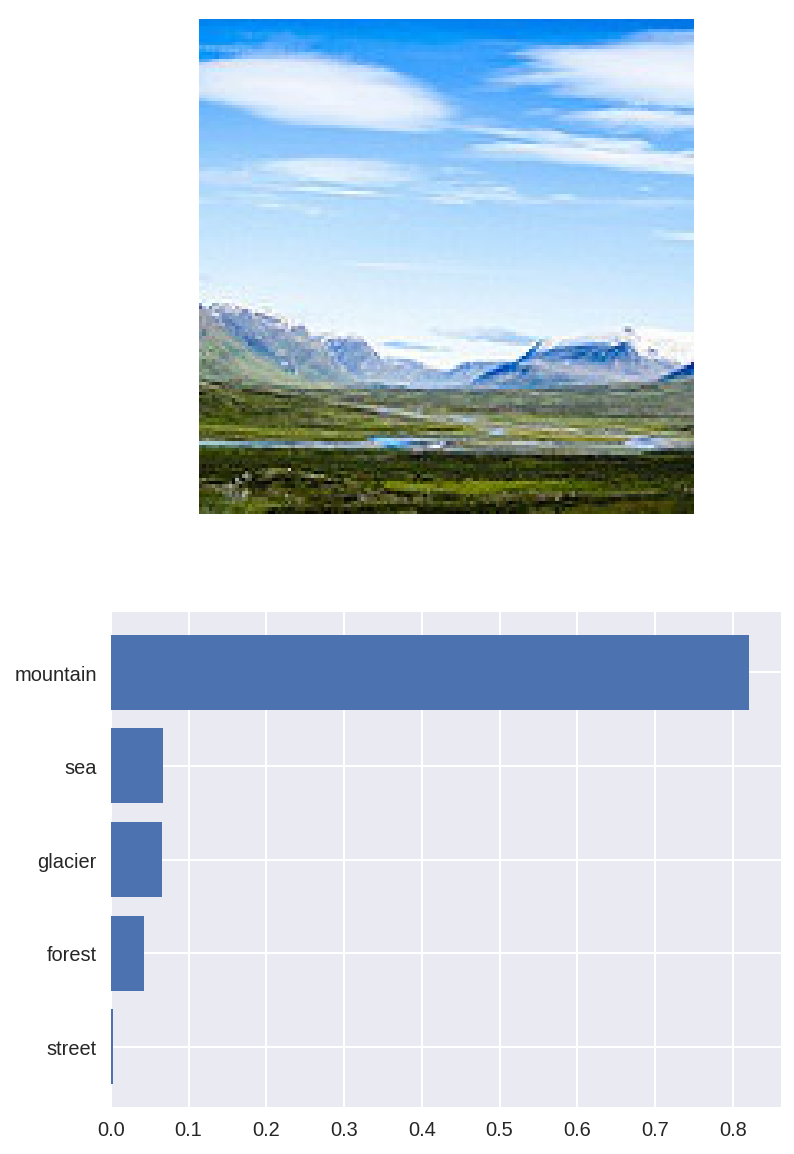

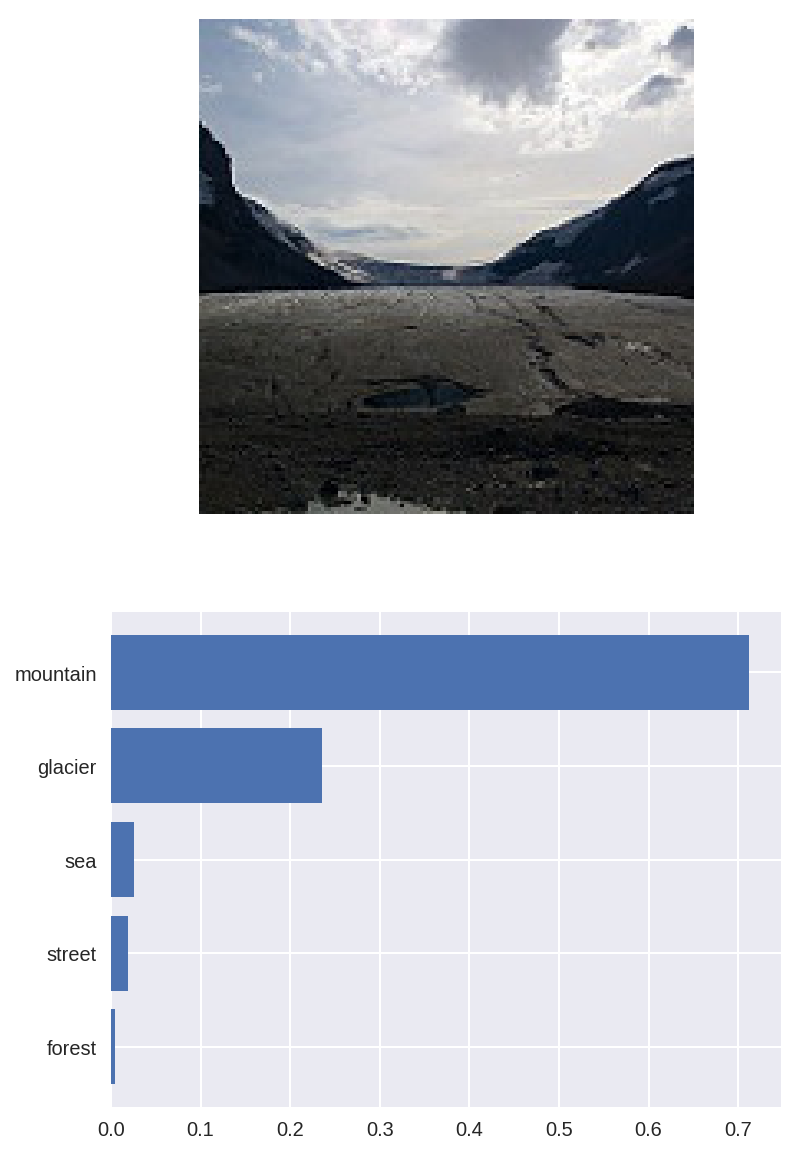

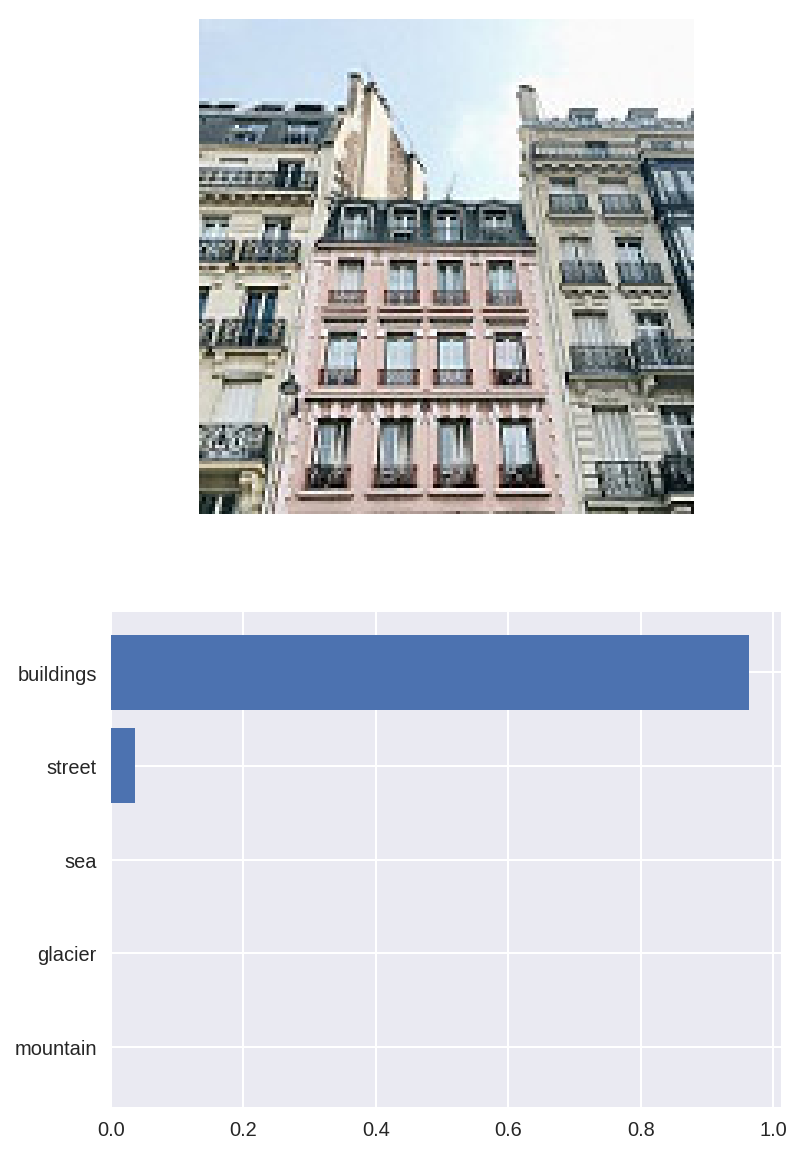

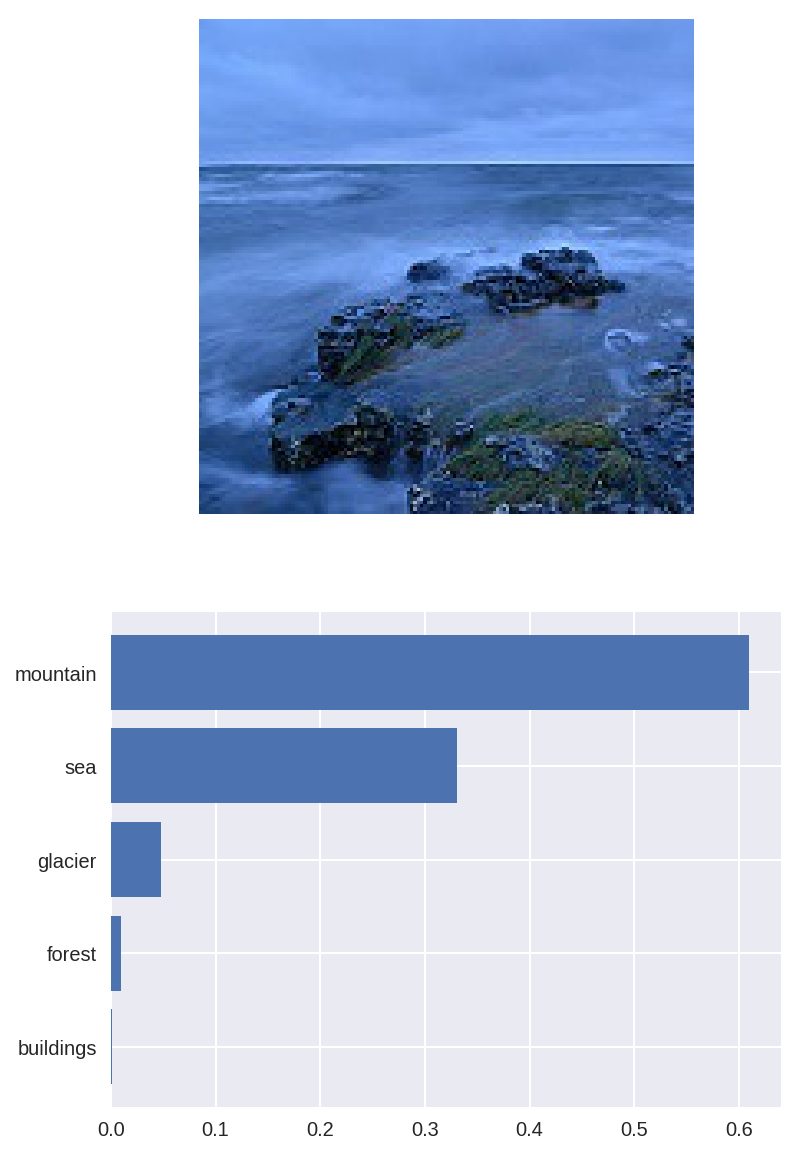

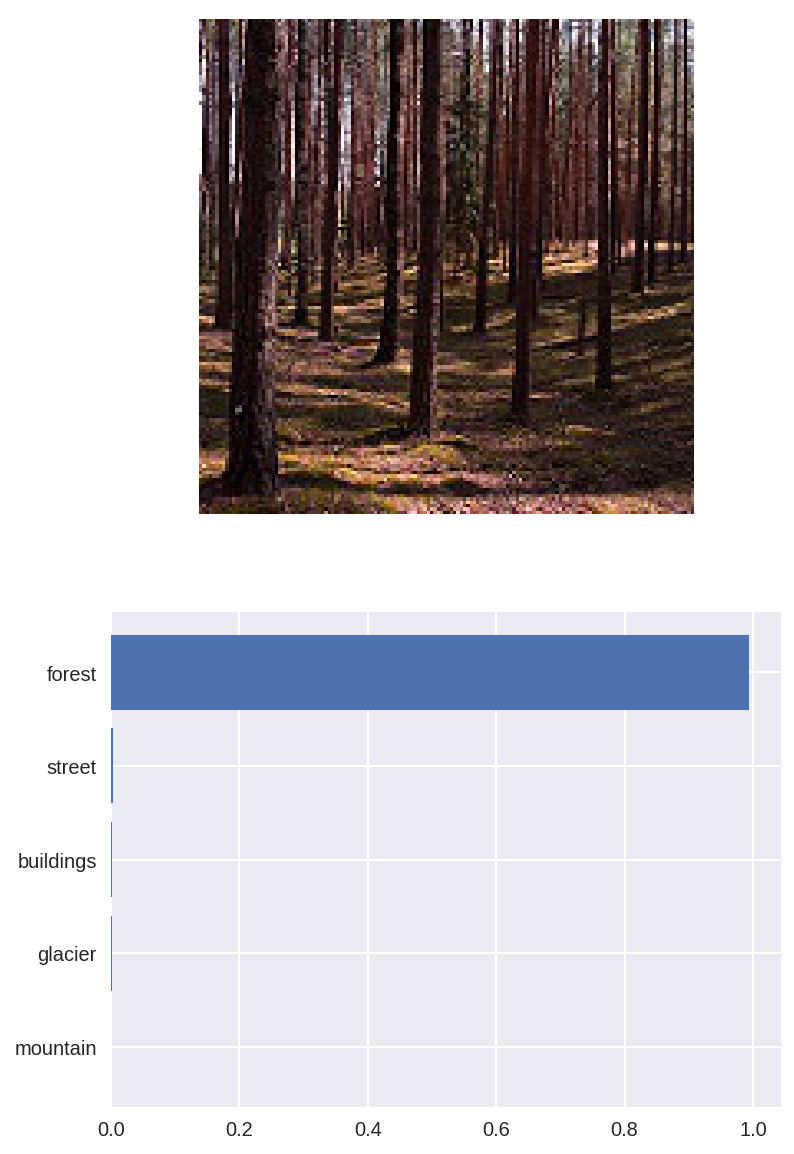

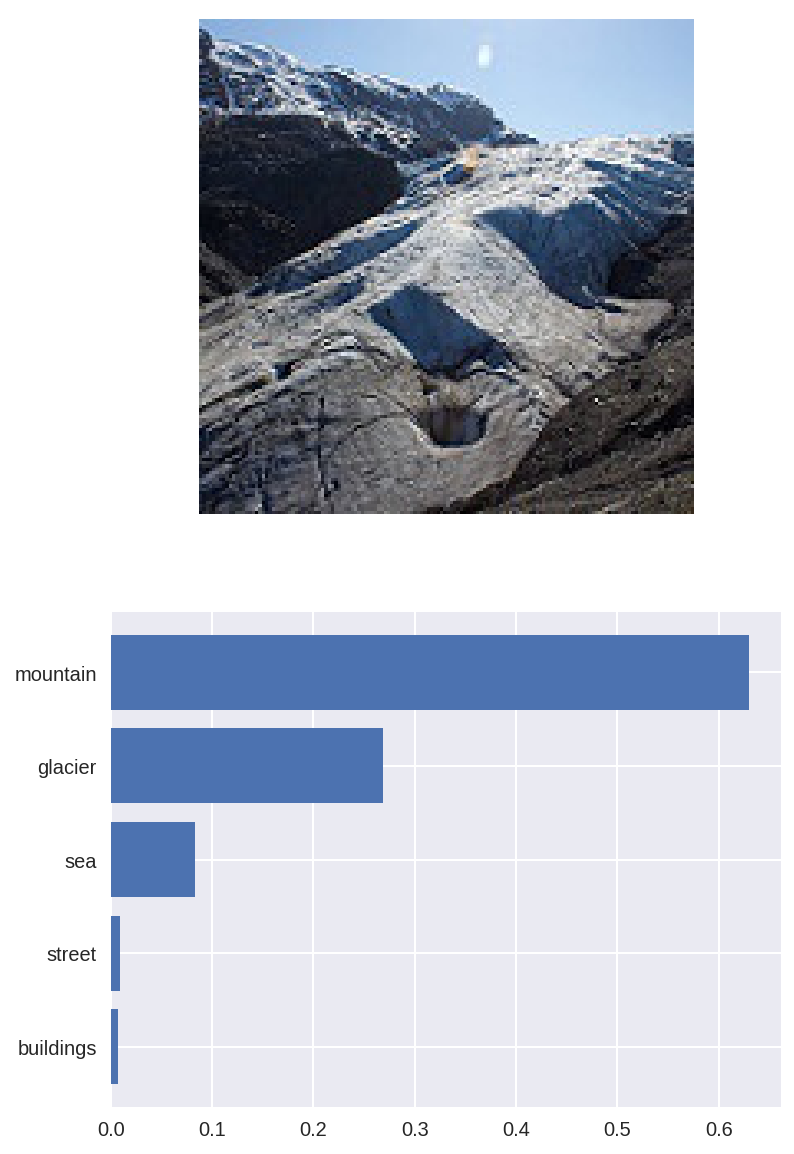

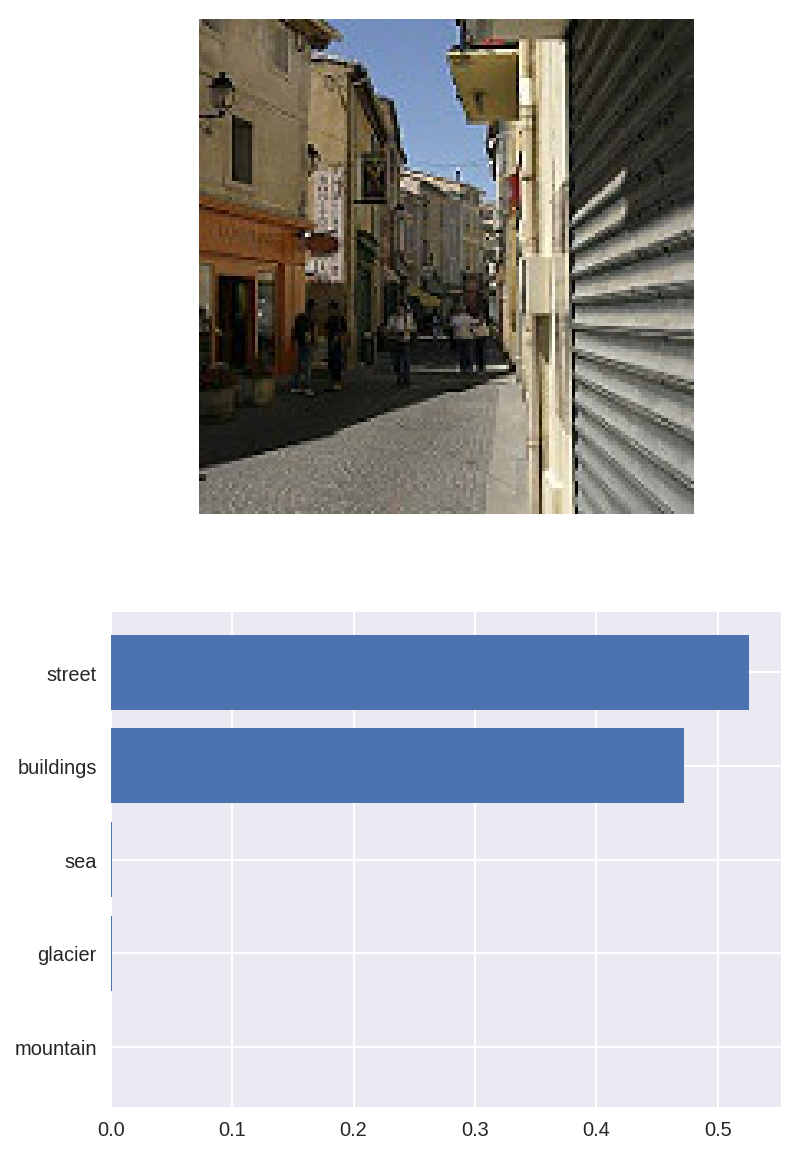

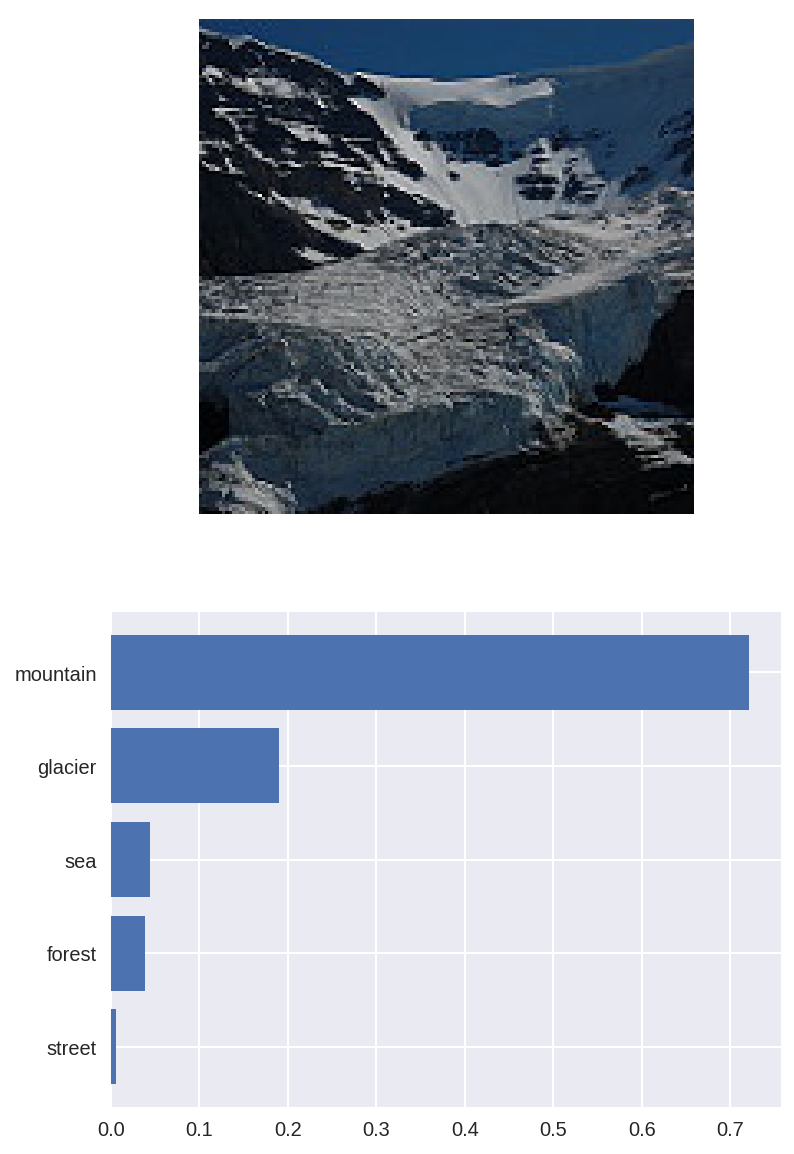

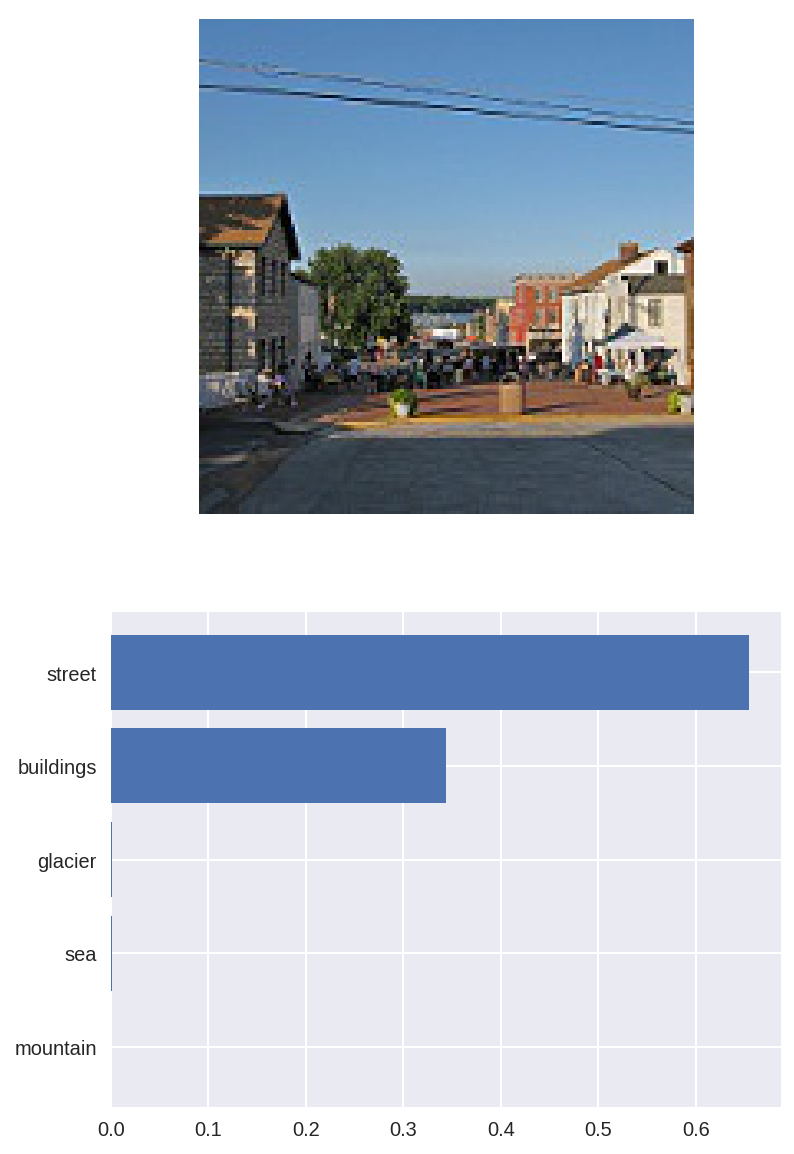

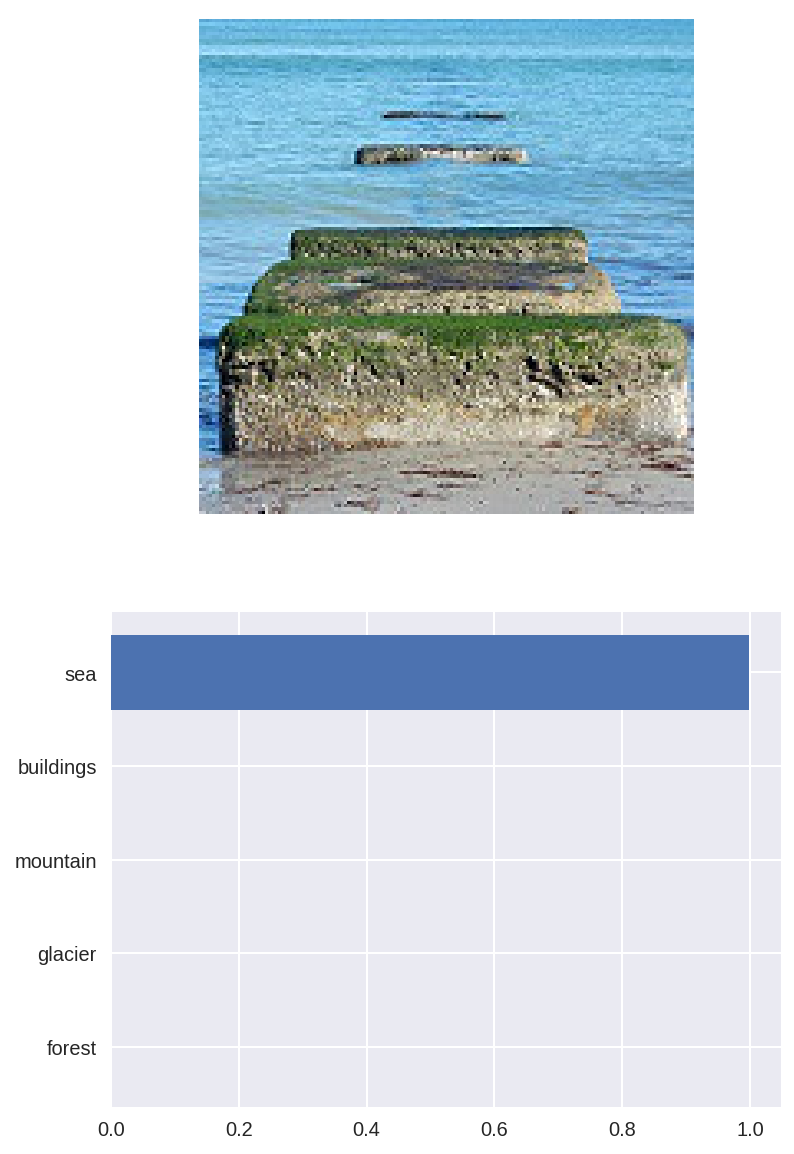

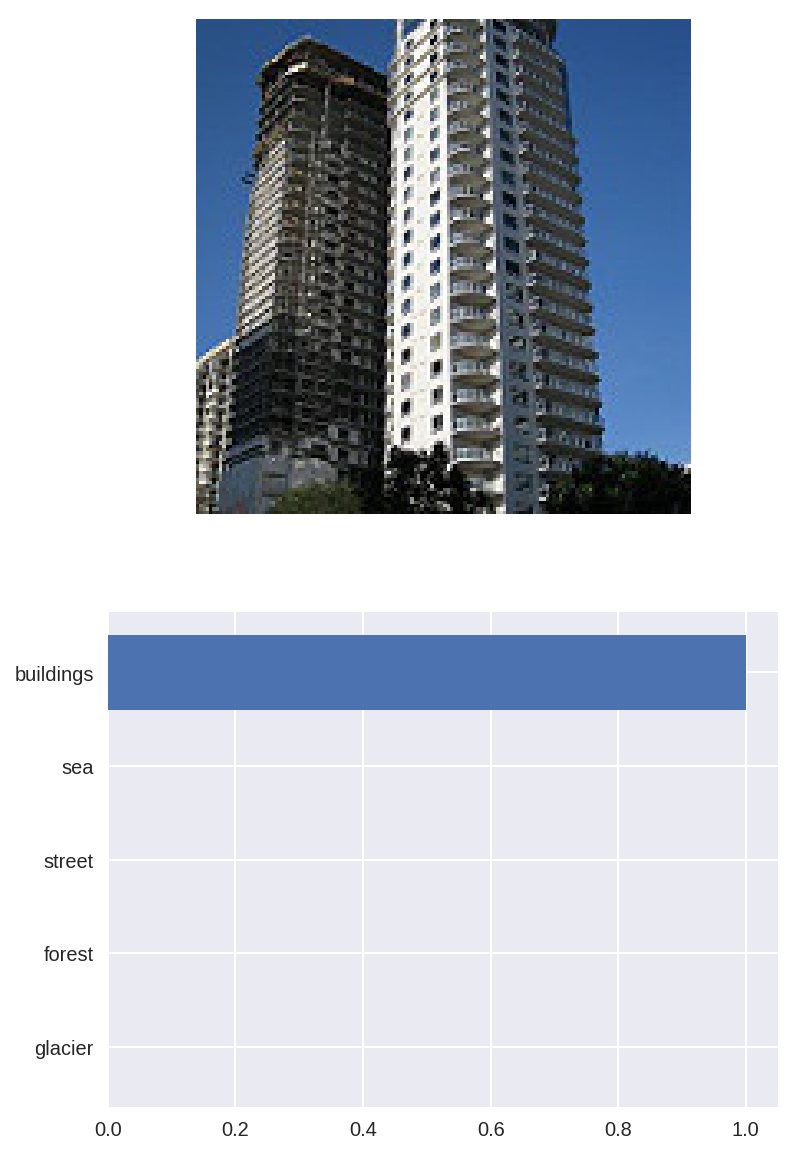

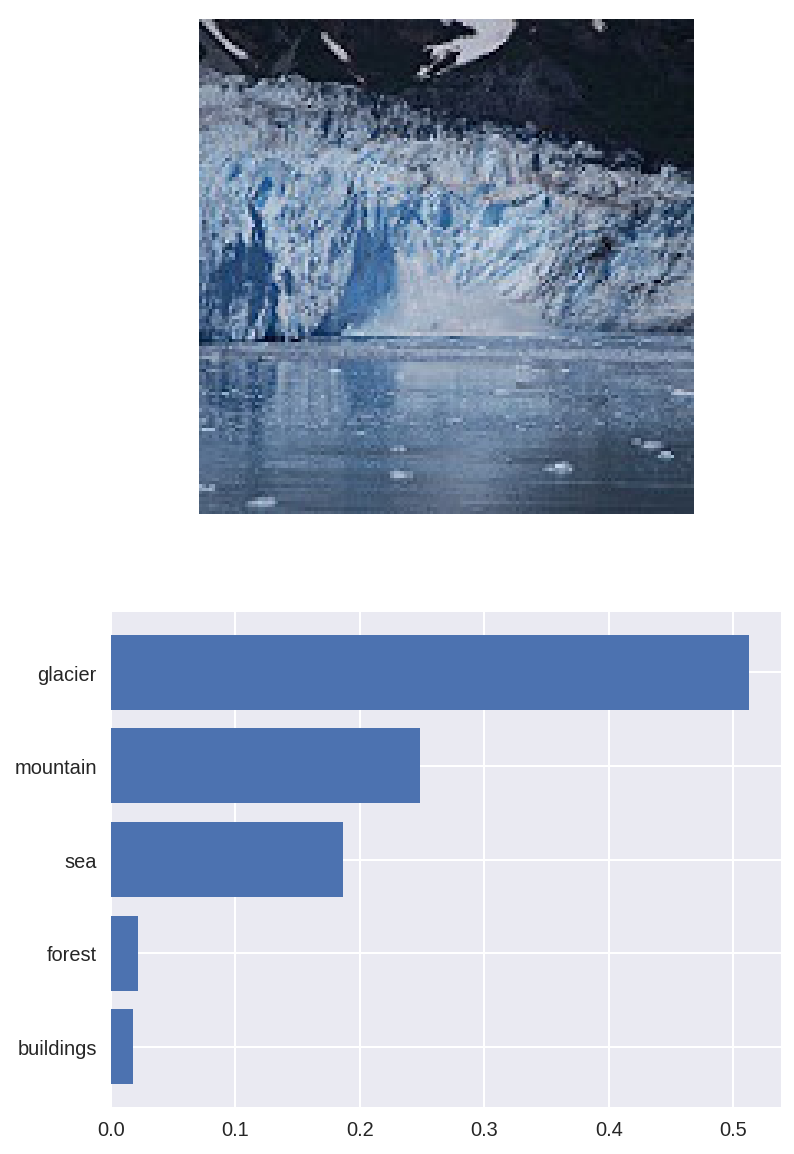

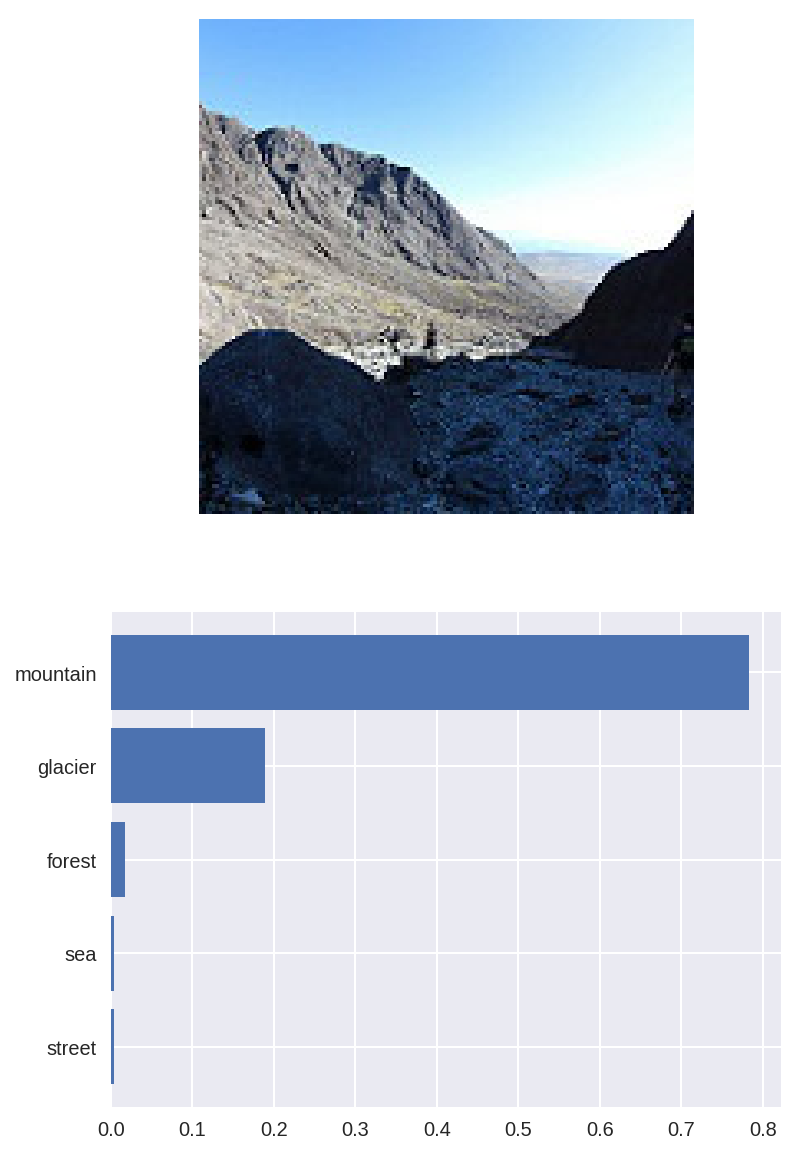

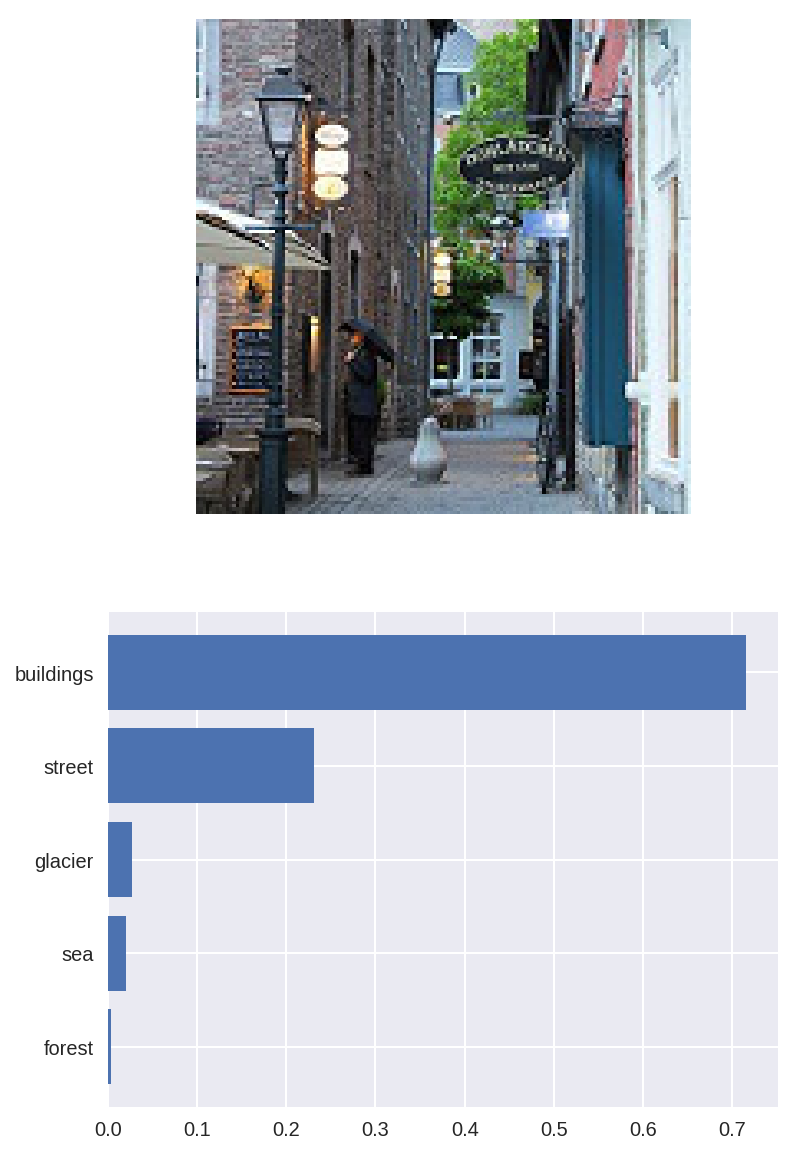

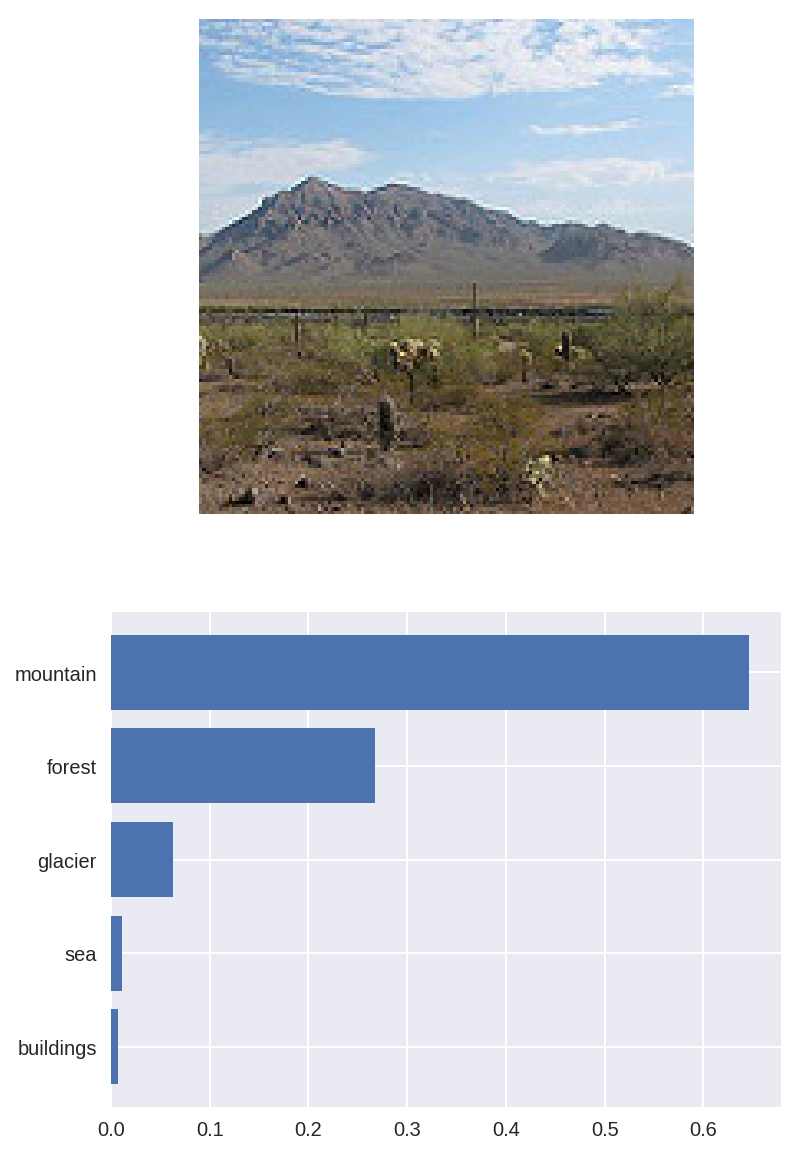

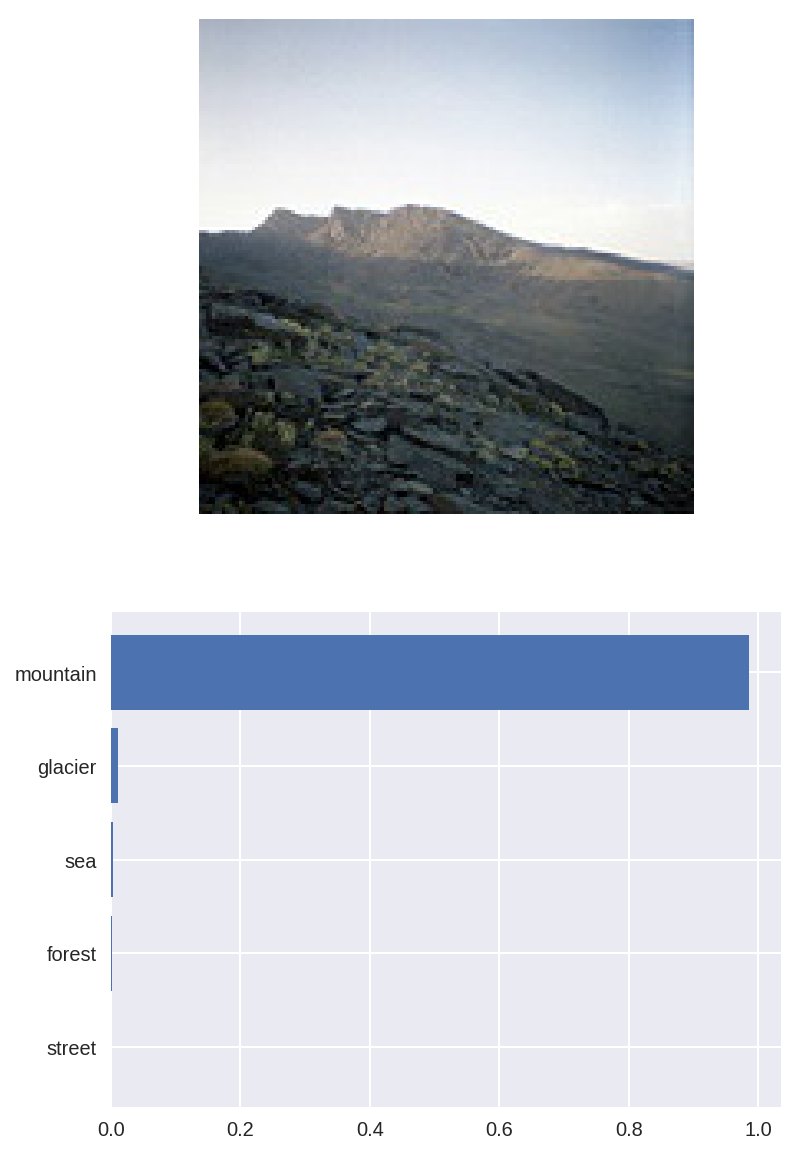

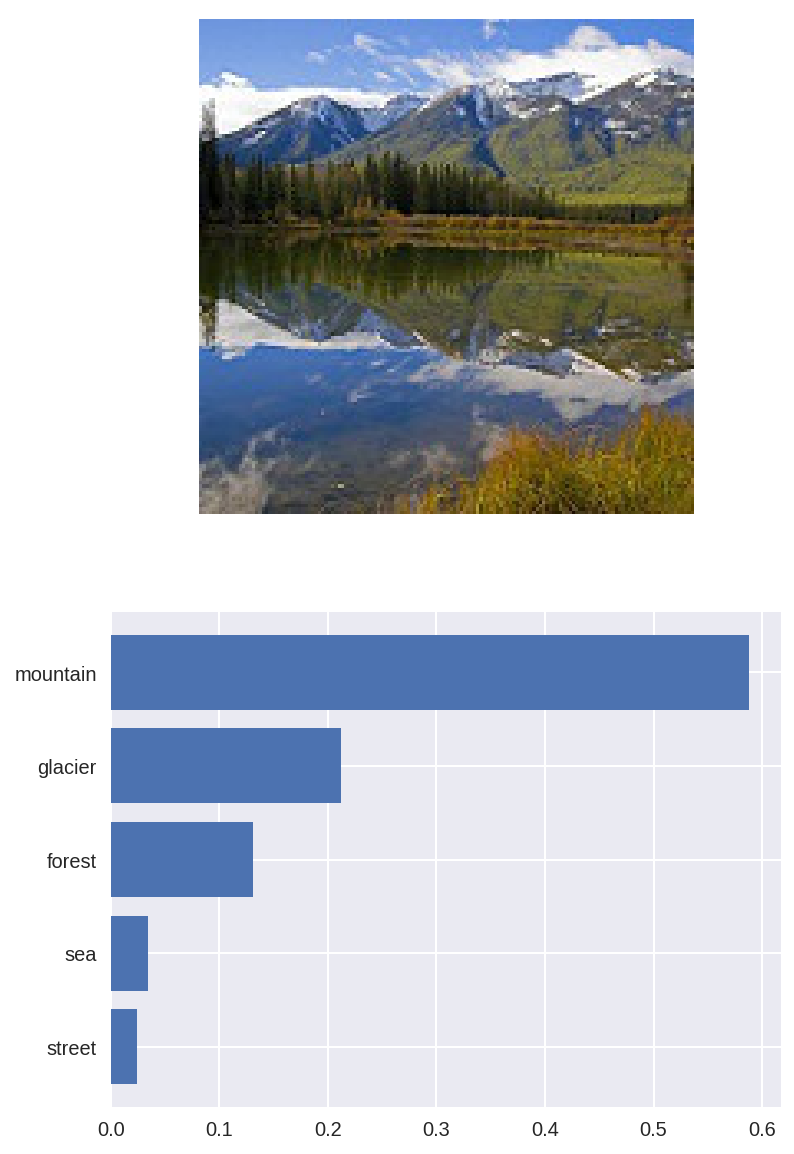

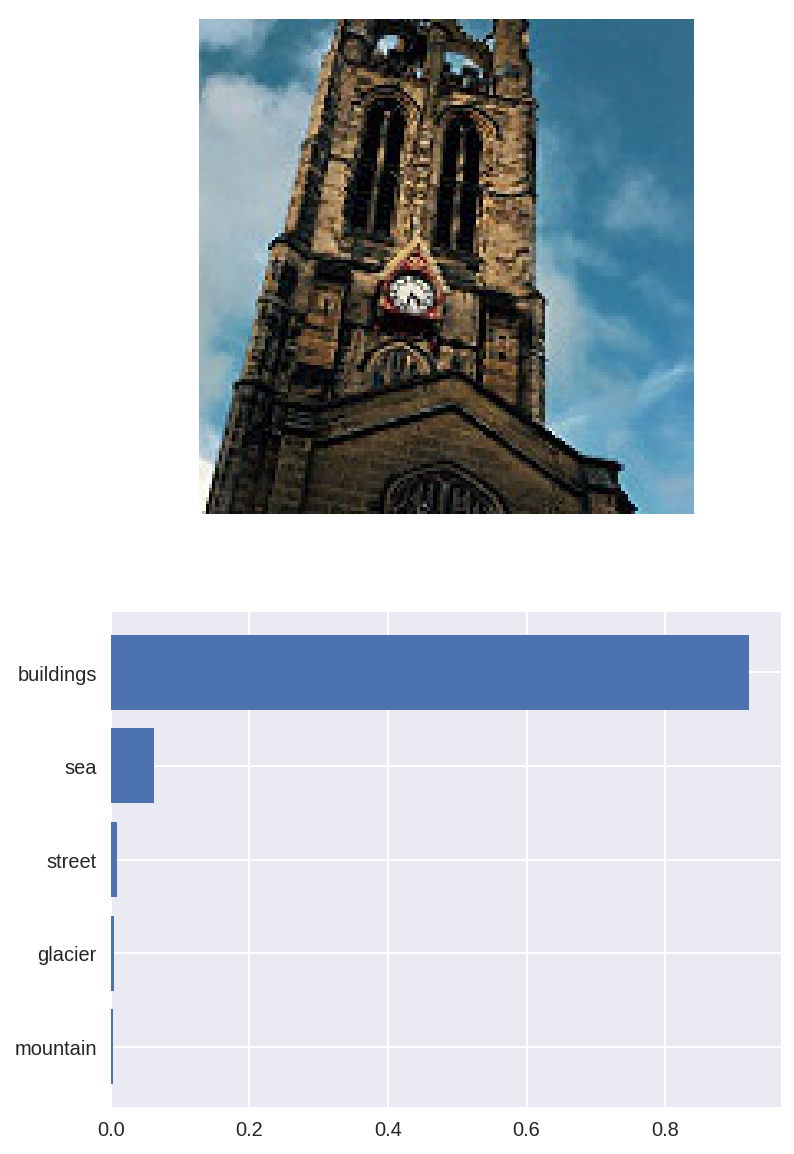

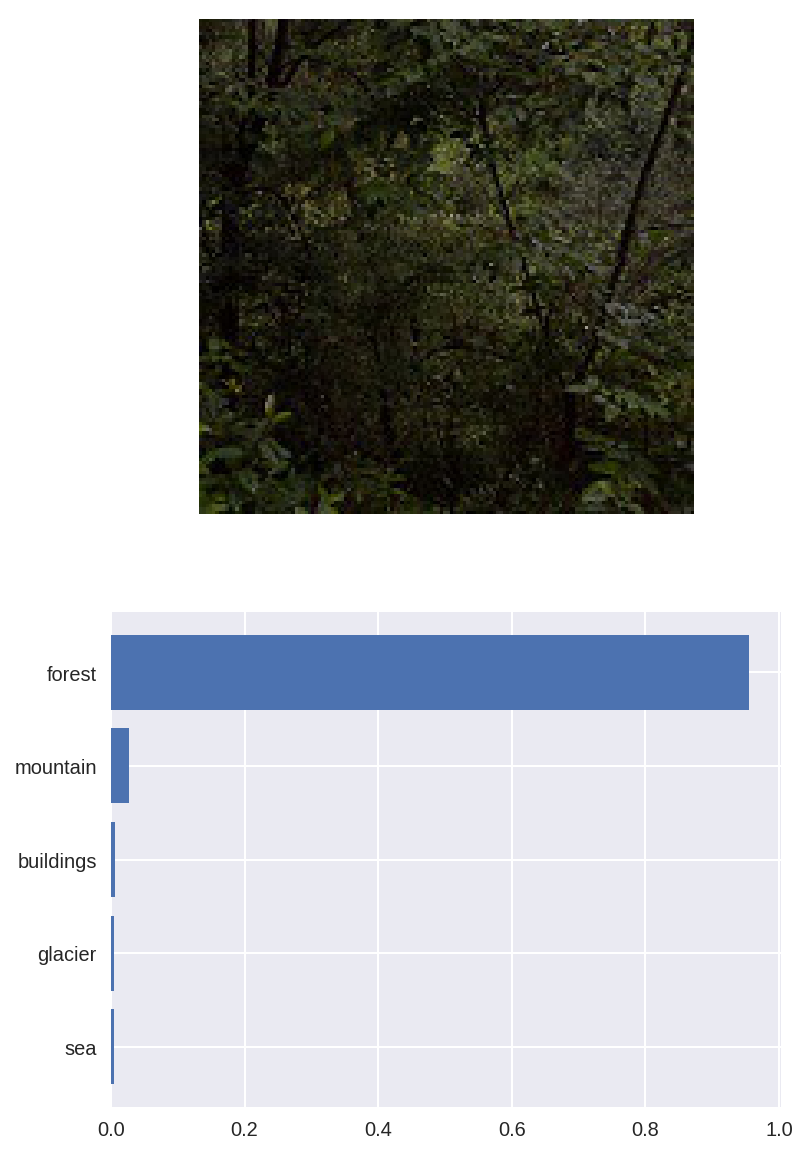

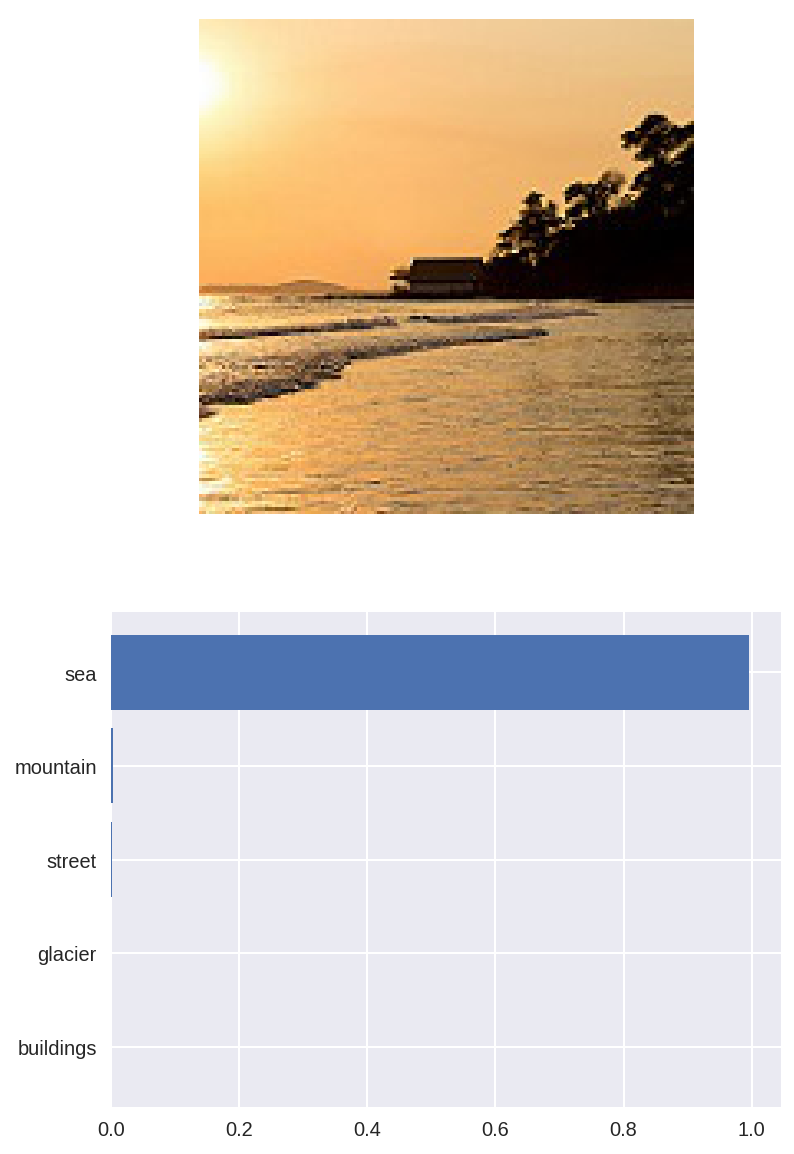

In [88]:
import time


for i in x[:20]:
  
  img = 'seg_pred/'+i
  img_filename = img.split('/')[-2]
  p, c = predict(img, loaded_model)
  view_classify(img, p, c, cat_to_name)
  
    
  
